In [ ]:
import pandas as pd

# Load the Excel file
df = pd.read_excel('sample_data/cleaned_yield_data.xlsx', skiprows=5)  # Skip header rows


# Keep only columns with data (automatically handles empty columns)
df = df.dropna(how='all', axis=1)  # Drop completely empty columns
df.columns = ["Crop", "Year", "Area", "Yield", "Production"]  # Now this should match
# Remove empty rows and reset index
df = df.dropna(how='all').reset_index(drop=True)

# Forward-fill missing crop names
df['Crop'] = df['Crop'].ffill()


In [ ]:
# Check for outliers (e.g., the 203356 yield for Potato 2024/25)
df['Yield'] = pd.to_numeric(df['Yield'], errors='coerce')
df['Production'] = pd.to_numeric(df['Production'], errors='coerce')

# Fix obvious data entry errors
df.loc[(df['Crop']=='Potato') & (df['Yield']>200000), 'Yield'] = 20335.6  # Assuming decimal error

In [ ]:
# Convert to tidy format (long form)
tidy_df = df.melt(id_vars=['Crop', 'Year'],
                 value_vars=['Area', 'Yield', 'Production'],
                 var_name='Metric',
                 value_name='Value')

# Add calculated metrics
df['Productivity'] = df['Production'] / df['Area']

In [ ]:
# Convert Year to proper datetime
df['Year'] = pd.to_datetime(df['Year'].str[:4]) + pd.offsets.YearEnd()

# Set as index for time series analysis
ts_df = df.set_index(['Crop', 'Year']).sort_index()

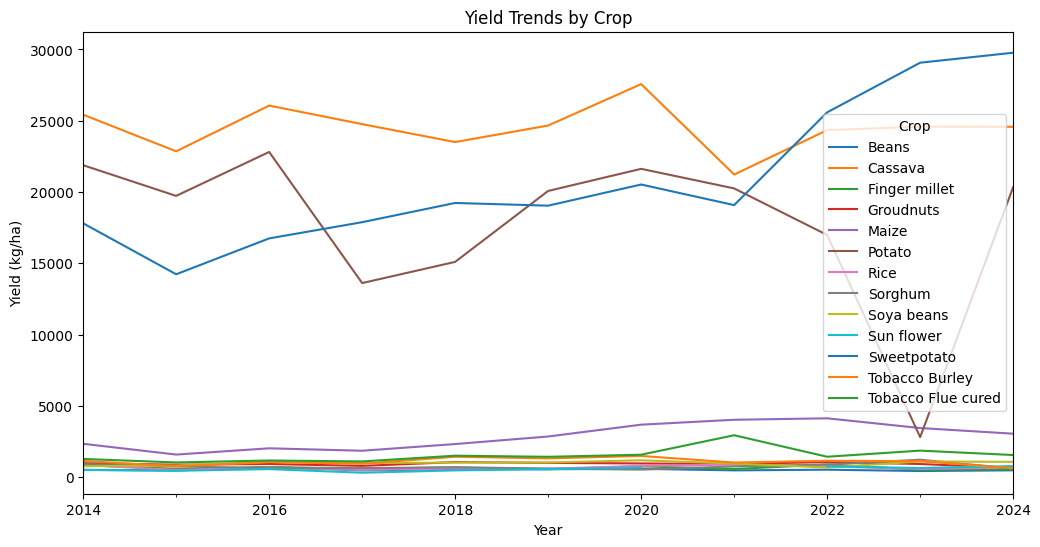

In [ ]:
import matplotlib.pyplot as plt

pivot = df.pivot(index='Year', columns='Crop', values='Yield')
pivot.plot(figsize=(12,6))
plt.title('Yield Trends by Crop')
plt.ylabel('Yield (kg/ha)')
plt.show()

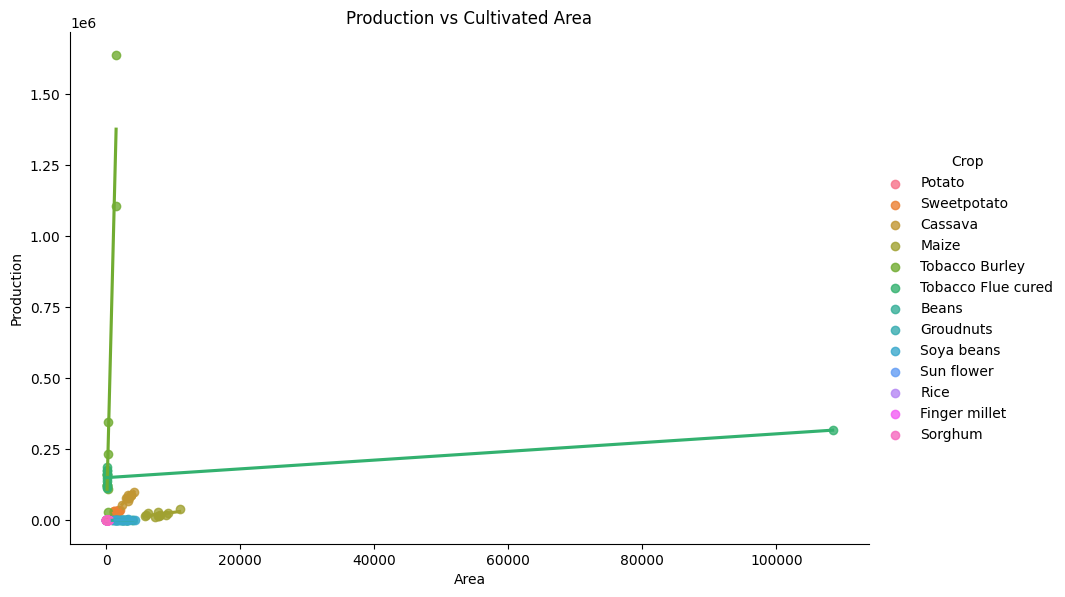

In [ ]:
import seaborn as sns

sns.lmplot(data=df, x='Area', y='Production', hue='Crop',
           height=6, aspect=1.5, ci=None)
plt.title('Production vs Cultivated Area')
plt.show()

In [ ]:
stats = df.groupby('Crop').agg({
    'Yield': ['mean', 'std', 'min', 'max'],
    'Production': 'sum'
})
print(stats)

                           Yield                                Production
                            mean          std      min      max        sum
Crop                                                                      
Beans                 517.363636    75.767107    423.0    698.0    14866.0
Cassava             24503.636364  1651.413896  21224.0  27568.0   893563.0
Finger millet         652.909091   125.751703    508.0    880.0     1824.0
Groudnuts             915.363636   118.078171    647.0   1053.0    22020.0
Maize                2839.181818   889.969080   1577.0   4121.0   241450.0
Potato              17743.690909  5728.265327   2800.0  22807.0    15077.0
Rice                  667.363636   131.786397    500.0    875.0       66.0
Sorghum               741.545455   197.780870    523.0   1217.0      694.0
Soya beans            964.090909   155.424872    668.0   1175.0    26421.0
Sun flower            564.300000   145.113787    304.0    769.0       81.0
Sweetpotato         20813

In [ ]:
# Save to new Excel file
df.to_excel('cleaned_yield_data.xlsx', index=False)

# Or to CSV
tidy_df.to_csv('tidy_yield_data.csv', index=False)

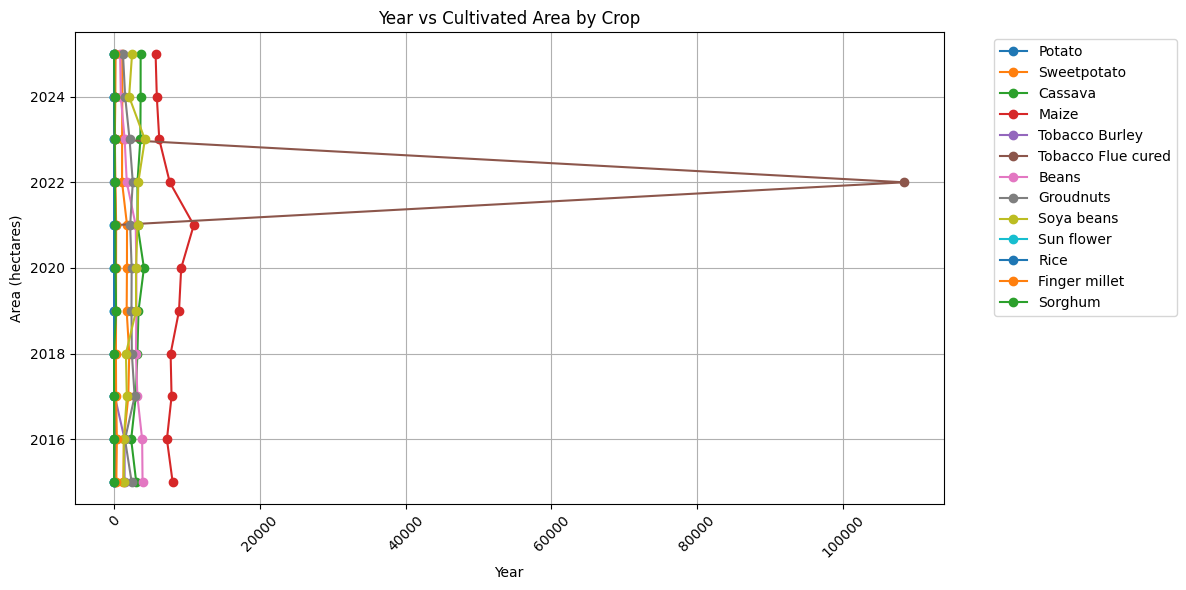

In [ ]:
plt.figure(figsize=(12, 6))
for crop in df['Crop'].unique():
    crop_data = df[df['Crop'] == crop]
    plt.plot(crop_data['Area'], crop_data['Year'], label=crop, marker='o')

plt.title('Year vs Cultivated Area by Crop')
plt.xlabel('Year')
plt.ylabel('Area (hectares)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px

fig = px.line(df, x='Year', y='Area', color='Crop',
              title='Cultivated Area Over Time',
              labels={'Area': 'Area (hectares)', 'Year': 'Harvest Year'},
              hover_data=['Yield', 'Production'],
              line_shape='spline', render_mode='svg')

fig.update_layout(hovermode='x unified')
fig.show()